<a href="https://colab.research.google.com/github/06yako14/stock-prediction/blob/dev/TimeSeriesModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列モデルによる日経平均株価予測

## 概要
2024年1月より新NISAの開始に伴い、株式投資への機運が高まっている。<br>
業務で触れている機械学習や統計解析をもとに日経平均株価の予測を行う。

### 使用ライブラリのインポート

In [13]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib
import seaborn as sns

import yfinance as yf

# 予測モデル
# 自己回帰モデル
# !pip install statsmodels
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_squared_error

# Pandasのオプション
pd.options.display.max_columns=100
pd.options.display.max_rows=50

%matplotlib inline

### データの読み込み

In [14]:
# 取得日付を指定
# start = detatime.datetime(1965, 1, 5) # yfinanceに保存されているデータの開始日
# end = datetime.datetime.today()

In [15]:
# 株（指標）の銘柄コード、ティッカーシンボルの設定
# 今回は日経平均株価
stock_code = '^N225'

In [16]:
# 株価取得
# nikkei = yf.downlod(tickers=stock_code, start=start, end=end)
nikkei = yf.download(tickers=stock_code)

[*********************100%%**********************]  1 of 1 completed


### データの確認

In [17]:
nikkei

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0
1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0
1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0
1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0
1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0
...,...,...,...,...,...,...
2024-07-10,41444.328125,41889.160156,41430.378906,41831.988281,41831.988281,134400000
2024-07-11,42343.718750,42426.769531,42102.460938,42224.019531,42224.019531,123000000
2024-07-12,41668.859375,41754.761719,41188.289062,41190.679688,41190.679688,130400000


### 欠損値の確認

In [18]:
nikkei.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### データの可視化

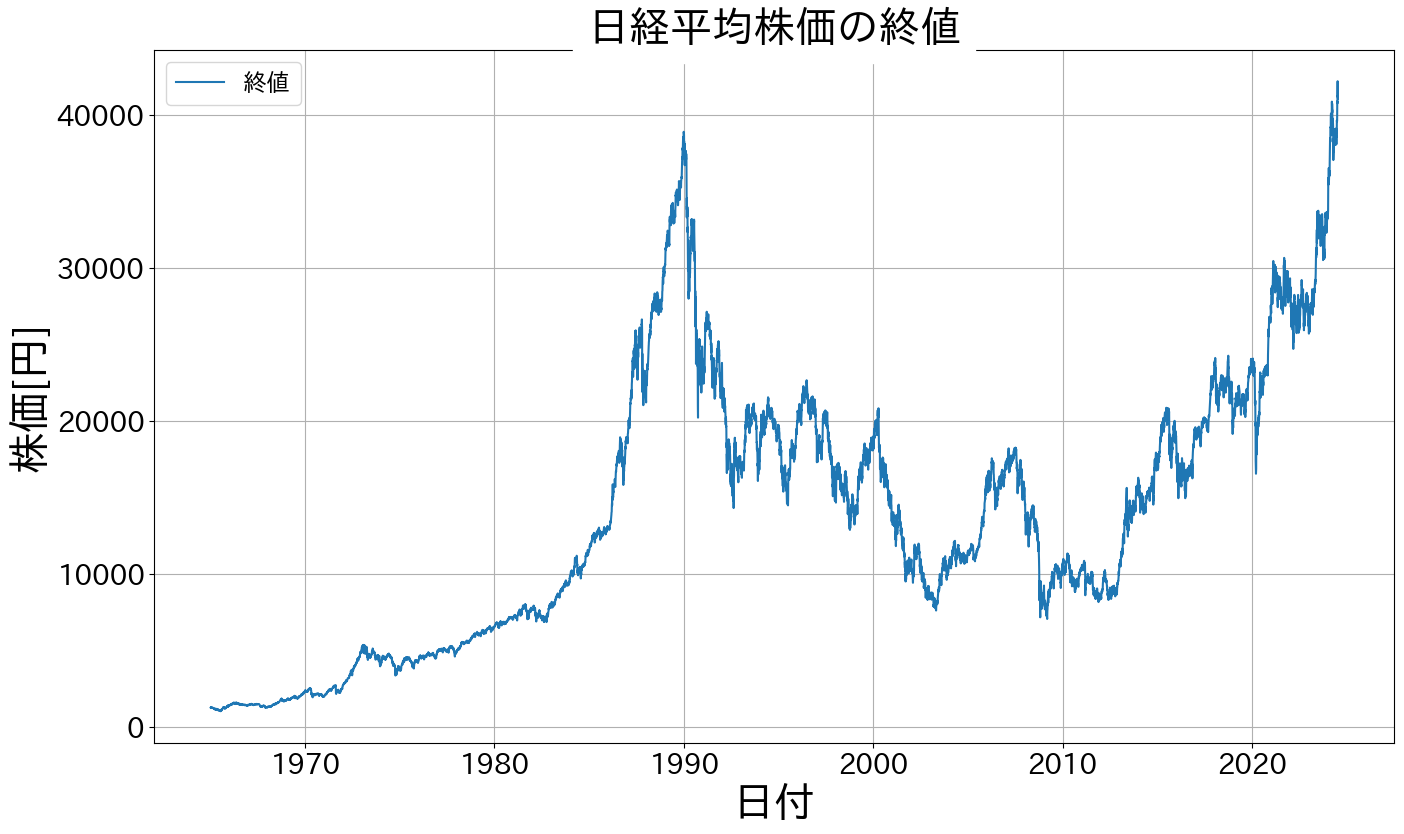

In [19]:
plt.figure(figsize=(16, 9))
plt.plot(nikkei.index, nikkei['Close'], label="終値")
plt.title('日経平均株価の終値', color='black', backgroundcolor='white', size=30, loc='center', fontname='IPAexGothic')
plt.xlabel('日付', color='black', size=30, fontname='IPAexGothic')
plt.ylabel('株価[円]', color='black', size=30, fontname='IPAexGothic')
plt.xticks(size=20)
plt.yticks(size=20)

plt.legend(loc="upper left", prop={'family': 'IPAexGothic', 'size':'xx-large'})
plt.grid()
plt.show()

### データセット作成

In [20]:
# 訓練データを準備
train_df = nikkei[:'2024-05-23']

In [21]:
train_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0
1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0
1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0
1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0
1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0
...,...,...,...,...,...,...
2024-05-17,38561.039062,38842.488281,38539.558594,38787.378906,38787.378906,133300000
2024-05-20,38761.710938,39437.160156,38703.699219,39069.679688,39069.679688,127400000
2024-05-21,39232.160156,39346.148438,38942.281250,38946.929688,38946.929688,106700000


### モデル構築

In [ ]:
# 過去30営業日を入力とする
min_lag = 30

# 5営業日先まで予測させる
len_test = 5

In [23]:
# モデルの学習
ar_model = AutoReg(train_df['Close'], lags=min_lag).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
